<a href="https://colab.research.google.com/github/sarath11999/colab3d/blob/main/Copy_of_SolarModelSarathlarge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import math

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
small_input_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_active_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_reactive_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_voltage_angles.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/measurements/measured_voltage_magnitudes.csv']

small_target_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/voltages/actual_voltage_magnitudes.csv',
                      '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/small-system/voltages/actual_voltage_angles.csv']

In [22]:
large_input_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_active_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_reactive_power.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_voltage_angles.csv',
                     '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/measurements/measured_voltage_magnitudes.csv']

large_required_input_paths = ['/content/drive/MyDrive/newfolder/measured_active_power_filtered.csv',
                              '/content/drive/MyDrive/newfolder/measured_reactive_power_filtered.csv',
                              '/content/drive/MyDrive/newfolder/measured_voltage_angles_filtered.csv',
                              '/content/drive/MyDrive/newfolder/measured_voltage_magnitudes_filtered.csv']

large_target_paths = ['/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/voltages/actual_voltage_magnitudes.csv',
                      '/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/voltages/actual_voltage_angles.csv']

In [ ]:
large_day14_input_paths = ['/content/drive/MyDrive/day14/measured_active_power.csv',
                           '/content/drive/MyDrive/day14/measured_reactive_power.csv',
                           '/content/drive/MyDrive/day14/measured_voltage_angles.csv',
                           '/content/drive/MyDrive/day14/measured_voltage_magnitudes.csv']

In [24]:
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
import numpy as np

class CustomDataset01(Dataset):
    def __init__(self, inputs, targets, input_scalers=None, target_scalers=None):
        self.inputs_df = [self.encode_time_and_dropzeros(input_path) for input_path in inputs]
        self.targets_df = [self.encode_time_and_dropzeros(target_path, target=True) for target_path in targets]

        # Initialize scalers if they are not passed
        if input_scalers is None:
            self.input_scalers = [StandardScaler() for _ in inputs]
        else:
            self.input_scalers = input_scalers

        if target_scalers is None:
            self.target_scalers = [StandardScaler() for _ in targets]
        else:
            self.target_scalers = target_scalers

        # Fit scalers only on inputs and targets
        self._fit_scalers()

    def encode_time_and_dropzeros(self, path, target=False):
        df = pd.read_csv(path, parse_dates=True, index_col='Timestep')
        if not target:
            # Ensure the index is a DatetimeIndex
            if not isinstance(df.index, pd.DatetimeIndex):
                raise ValueError("The DataFrame index must be a DatetimeIndex.")

            # Extract relevant time information
            hours = df.index.hour
            day_of_week = df.index.dayofweek  # Monday=0, Sunday=6
            day_of_year = df.index.dayofyear   # 1 through 365 (or 366 for leap year)
            day_of_month = df.index.day        # 1 through 31

            # Calculate sine and cosine encodings
            df['sin_hour'] = np.sin(2 * np.pi * hours / 24)
            df['cos_hour'] = np.cos(2 * np.pi * hours / 24)

            df['sin_day_of_week'] = np.sin(2 * np.pi * day_of_week / 7)
            df['cos_day_of_week'] = np.cos(2 * np.pi * day_of_week / 7)

            df['sin_day_of_year'] = np.sin(2 * np.pi * day_of_year / 365)
            df['cos_day_of_year'] = np.cos(2 * np.pi * day_of_year / 365)

            df['sin_day_of_month'] = np.sin(2 * np.pi * day_of_month / 31)
            df['cos_day_of_month'] = np.cos(2 * np.pi * day_of_month / 31)

            # df = df.loc[:, (df != 0).any(axis=0)]
        return df

    def _fit_scalers(self):
        """Fit the scalers on the inputs and targets"""
        for i, input_df in enumerate(self.inputs_df):
            self.input_scalers[i].fit(input_df)

        for j, target_df in enumerate(self.targets_df):
            self.target_scalers[j].fit(target_df)

    def standardize_data(self, df, scaler):
        """Standardize the given DataFrame using the scaler"""
        return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

    def __len__(self):
        return len(self.inputs_df[0])

    def __getitem__(self, index):
        # Standardize inputs
        inputs = [torch.tensor(self.standardize_data(input_df.iloc[[index]], self.input_scalers[i]).values[0], dtype=torch.float32)
                  for i, input_df in enumerate(self.inputs_df)]

        # Standardize targets
        targets = [torch.tensor(self.standardize_data(target_df.iloc[[index]], self.target_scalers[j]).values[0], dtype=torch.float32)
                   for j, target_df in enumerate(self.targets_df)]

        return (*inputs, *targets)


def train_test_split(dataset, test_days=10):
    test_length = test_days * 48
    train_length = len(dataset) - test_length
    train_data = Subset(dataset, range(train_length))
    test_data = Subset(dataset, range(train_length, len(dataset)))
    return train_data, test_data

 **Small Dataset**

In [25]:
full_dataset=CustomDataset01(inputs=large_required_input_paths, targets=large_target_paths)

In [26]:
# Print means and standard deviations for input data scalers
print("Input Data Scalers:")
for i, scaler in enumerate(full_dataset.input_scalers):
    print(f"Input {i + 1} Mean: {scaler.mean_}")
    print(f"Input {i + 1} Standard Deviation: {scaler.scale_}")

# Print means and standard deviations for target data scalers
print("\nTarget Data Scalers:")
for j, scaler in enumerate(full_dataset.target_scalers):
    print(f"Target {j + 1} Mean: {scaler.mean_}")
    print(f"Target {j + 1} Standard Deviation: {scaler.scale_}")


Input Data Scalers:
Input 1 Mean: [-1.44335092e+03 -1.49420661e+03 -1.34262780e+03 ... -6.23197782e-01
  2.23665022e-03 -3.31058882e-02]
Input 1 Standard Deviation: [3.92447686e+02 3.22223205e+02 3.63282991e+02 ... 3.10411394e-01
 7.18478552e-01 6.94757201e-01]
Input 2 Mean: [-5.13510498e+02 -4.17609852e+02 -4.57630593e+02 ... -6.23197782e-01
  2.23665022e-03 -3.31058882e-02]
Input 2 Standard Deviation: [138.77467352 116.9518031  130.8085159  ...   0.31041139   0.71847855
   0.6947572 ]
Input 3 Mean: [-1.68777611e-07 -2.09439530e+00  2.09439494e+00 -2.11518290e+00
  2.08158592e+00 -1.05399365e+00  3.11348603e+00 -1.06222654e+00
 -1.05809812e+00 -2.44730140e-02 -1.06330221e+00 -8.33333333e-02
 -6.32979509e-01  1.08325324e-02  2.47245482e-03  6.53420383e-01
 -6.23197782e-01  2.23665022e-03 -3.31058882e-02]
Input 3 Standard Deviation: [5.70756596e-08 4.40611548e-08 5.18252036e-08 3.53705795e-03
 6.76500725e-03 2.02119647e-03 1.02605231e-02 6.37380770e-03
 6.15329850e-03 9.01564804e-03 7.3

In [27]:
pd.read_csv(large_required_input_paths[0], parse_dates=True, index_col='Timestep')

,P9UDT12866-P9UHS16_1247X.1,P9UDT12866-P9UHS16_1247X.2,P9UDT12866-P9UHS16_1247X.3,P9ULV1022.1,P9ULV1022.2,P9ULV1071.1,P9ULV1071.2,P9ULV1147.1,P9ULV1315.2,P9ULV1256.1,...,P9ULV113279.1,P9ULV113279.2,P9ULV122699.1,P9ULV122699.2,P9ULV75895.2,P9ULV75895.3,P9ULV112823.1,P9ULV112823.2,P9ULV112311.2,P9ULV112311.3
Timestep,,,,,,,,,,,,,,,,,,,,,
2018-04-01 07:00:00,-1397.563177,-1403.755003,-1236.063400,1.379009,1.379009,0.701141,0.701141,0.472348,0.406289,6.772303,...,0.052961,0.052961,1.202237,1.202237,9.011875,9.011721,8.614558,8.614502,15.452283,15.451937
2018-04-01 07:15:00,-1357.616972,-1353.245377,-1206.545996,1.238382,1.238382,0.709069,0.709069,0.332611,0.472924,6.080839,...,0.053114,0.053114,1.215834,1.215834,9.364550,9.364414,8.179987,8.179921,15.502971,15.502667
2018-04-01 07:30:00,-1466.746857,-1417.353914,-1291.980604,1.009080,1.009080,0.810057,0.810057,1.077815,0.605517,6.142405,...,0.055758,0.055758,1.396600,1.396600,9.698032,9.697840,8.234813,8.234707,15.592618,15.592194
2018-04-01 07:45:00,-1445.523610,-1403.941082,-1269.714567,0.937074,0.937074,0.493778,0.493778,0.624502,0.463147,6.019147,...,0.054083,0.054083,1.368404,1.368404,9.458455,9.458256,8.013578,8.013497,15.167330,15.166900
2018-04-01 08:00:00,-1393.767353,-1389.563124,-1254.820105,1.040232,1.040232,0.496233,0.496233,-0.043717,0.460502,6.040140,...,0.053732,0.053732,1.745808,1.745808,9.531256,9.531101,7.998120,7.998041,15.149759,15.149411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-29 17:45:00,-2904.263527,-2663.290619,-2727.199955,3.113428,3.113428,0.563482,0.563482,5.018006,3.121644,6.288653,...,1.197402,1.197402,3.066710,3.066710,10.720992,10.720945,12.793688,12.793107,20.333677,20.333545
2018-06-29 18:00:00,-2889.214774,-2634.000669,-2685.752630,3.194856,3.194856,0.579321,0.579321,2.935811,3.197169,6.465422,...,1.173666,1.173666,3.147710,3.147710,11.564883,11.564820,13.051141,13.050538,20.810762,20.810625
2018-06-29 18:15:00,-2937.734778,-2688.721986,-2758.398660,3.088741,3.088741,0.561135,0.561135,3.073067,3.085006,6.262456,...,1.087795,1.087795,3.043305,3.043305,11.393285,11.393251,12.541282,12.540683,20.045331,20.045256


In [28]:
# Split dataset
train_data, test_data = train_test_split(full_dataset, test_days=10)

In [29]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [30]:
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)
for training_data in train_loader:
  print(f"The shapes are: {[data.shape for data in training_data]}")
  break

The shapes are: [torch.Size([256, 2892]), torch.Size([256, 2895]), torch.Size([256, 19]), torch.Size([256, 433]), torch.Size([256, 8515]), torch.Size([256, 8515])]


In [ ]:
# The shapes are: [torch.Size([256, 3260]), torch.Size([256, 3266]), torch.Size([256, 19]), torch.Size([256, 1711]), torch.Size([256, 8515]), torch.Size([256, 8515])]

In [12]:
for training_data in train_loader:
  print(f"The shapes are: {[data[0][0] for data in training_data]}")
  break

The shapes are: [tensor(-0.3957), tensor(-0.8366), tensor(-0.1062), tensor(0.1573), tensor(-0.5053), tensor(-0.1062)]


In [31]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=256):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=0.1)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)  # Add batch dimension
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         seq_len = x.size(1)
#         x = x + self.pe[:, :seq_len].clone().detach()
#         return self.dropout(x)


class TransformerForecastingModel01(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, output_dim, custom_linear_layers_dim=None, max_len = 256):
        super(TransformerForecastingModel01, self).__init__()
        # Positional encoding
        # self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.input_proj1 = nn.Linear(input_dim[0], d_model)
        self.input_proj2 = nn.Linear(input_dim[1], d_model)
        self.input_proj3 = nn.Linear(input_dim[2], d_model)
        self.input_proj4 = nn.Linear(input_dim[3], d_model)


        encoder_layer1 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder1 = nn.TransformerEncoder(encoder_layer1, num_layers=num_encoder_layers)

        encoder_layer2 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder2 = nn.TransformerEncoder(encoder_layer2, num_layers=num_encoder_layers)

        encoder_layer3 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder3 = nn.TransformerEncoder(encoder_layer3, num_layers=num_encoder_layers)

        encoder_layer4 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder4 = nn.TransformerEncoder(encoder_layer4, num_layers=num_encoder_layers)

        if custom_linear_layers_dim:
            custom_layers = []
            for dim in custom_linear_layers_dim:
                custom_layers.append(nn.Linear(d_model, dim))
                custom_layers.append(nn.Mish())
                d_model = dim
            self.custom_layers1 = nn.Sequential(*custom_layers)
            self.custom_layers2 = nn.Sequential(*custom_layers)
        else:
            self.custom_layers1 = None
            self.custom_layers2 = None

        self.final_proj1 = nn.Linear(d_model, output_dim[0])
        self.final_proj2 = nn.Linear(d_model, output_dim[1])

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src1, src2, src3, src4):
        src1 = self.input_proj1(src1)
        src2 = self.input_proj2(src2)
        src3 = self.input_proj3(src3)
        src4 = self.input_proj4(src4)

        # Apply positional encoding
        # src1 = self.positional_encoding(src1)
        # src2 = self.positional_encoding(src2)
        # src3 = self.positional_encoding(src3)
        # src4 = self.positional_encoding(src4)


        transformer_output1 = self.transformer_encoder1(src1)
        transformer_output2 = self.transformer_encoder2(src2)
        transformer_output3 = self.transformer_encoder3(src3)
        transformer_output4 = self.transformer_encoder4(src4)

        transformer_output = (transformer_output1 + transformer_output2 +
                              transformer_output3 + transformer_output4) / 4

        if self.custom_layers1:
            transformer_output1 = self.custom_layers1(transformer_output)
            transformer_output2 = self.custom_layers2(transformer_output)
        else:
            transformer_output1 = transformer_output
            transformer_output2 = transformer_output

        transformer_output1 = self.final_proj1(transformer_output1)
        transformer_output2 = self.final_proj2(transformer_output2)

        return transformer_output1, transformer_output2

In [14]:
# The shapes are: [torch.Size([256, 2892]), torch.Size([256, 2895]), torch.Size([256, 19]), torch.Size([256, 433]), torch.Size([256, 8515]), torch.Size([256, 8515])]

# [ ]


The shapes are: [torch.Size([256, 3260]), torch.Size([256, 3266]), torch.Size([256, 19]), torch.Size([256, 1711]), torch.Size([256, 8515]), torch.Size([256, 8515])]


In [32]:
model01= TransformerForecastingModel01(
    input_dim=[2892, 2895, 19, 433],  # dimensions of each input
    d_model=256,
    nhead=32,
    num_encoder_layers=1,
    dim_feedforward=4,
    dropout=0.7,
    output_dim=[8515, 8515],  # dimensions of each output
    custom_linear_layers_dim=[128, 512, 128, 512, 128]
)

In [33]:
loss01=nn.L1Loss()
optimizer01= torch.optim.Adam(model01.parameters(), lr=0.01)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
# Ensure to use the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize lists to record losses and outputs
train_losses = []
test_losses = []
train_op_1 = []
train_op_2 = []
test_op_1=[]
test_op_2=[]
model01.to(device)

# Load pre-trained weights if available
# model01.load_state_dict(torch.load('model_weights.pth'))

epochs = 2
for epoch in range(epochs):
    model01.train()
    total_train_loss = 0  # Track total loss for this epoch

    for data in train_loader:
        input1, input2, input3, input4, target1, target2 = [x.to(device) for x in data]

        optimizer01.zero_grad()  # Zero the gradients

        output1, output2 = model01(input1, input2, input3, input4)
        if epoch==epochs-1:
          train_op_1.extend(output1.detach().cpu().numpy())
          train_op_2.extend(output2.detach().cpu().numpy())

        # Calculate loss on standardized values
        loss1 = loss01(output1.squeeze(), target1)
        loss2 = loss01(output2.squeeze(), target2)
        combined_loss = loss1 + loss2  # Combine losses

        combined_loss.backward()  # Backpropagation
        optimizer01.step()  # Update weights

        total_train_loss += combined_loss.item()  # Accumulate loss

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Perform inference
    model01.eval()
    total_test_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            input1, input2, input3, input4, target1, target2 = [x.to(device) for x in data]

            # Perform forward pass
            output1, output2 = model01(input1, input2, input3, input4)
            if epoch==epochs-1:
              test_op_1.extend(output1.detach().cpu().numpy())
              test_op_2.extend(output2.detach().cpu().numpy())

            # Calculate loss on standardized values
            loss1 = loss01(output1.squeeze(), target1)
            loss2 = loss01(output2.squeeze(), target2)
            combined_loss = loss1 + loss2

            total_test_loss += combined_loss.item()  # Accumulate loss

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")


Epoch 1/2, Train Loss: 1.40644690990448, Test Loss: 3.038571000099182
Epoch 2/2, Train Loss: 1.0682274540265402, Test Loss: 1.5273631811141968


In [36]:
def prepare_future_data(future_data_paths, dataset):
    future_data_df = [dataset.encode_time_and_dropzeros(path) for path in future_data_paths]

    # Standardize the future data
    standardized_future_data = [
        dataset.standardize_data(df, scaler)
        for df, scaler in zip(future_data_df, dataset.input_scalers)
    ]

    # Convert to tensors
    future_data_tensors = [
        torch.tensor(df.values, dtype=torch.float32)
        for df in standardized_future_data
    ]

    return future_data_tensors

In [41]:
# Define paths for future data
large_day14_input_paths = [
    '/content/drive/MyDrive/day14/measured_active_power.csv',
    '/content/drive/MyDrive/day14/measured_reactive_power.csv',
    '/content/drive/MyDrive/day14/measured_voltage_angles.csv',
    '/content/drive/MyDrive/day14/measured_voltage_magnitudes.csv'
]

In [57]:
class CustomDataset03(Dataset):
    def __init__(self, inputs, input_scalers=None):
        self.inputs_df = [self.encode_time_and_dropzeros(input_path) for input_path in inputs]

        # Initialize scalers if they are not passed
        if input_scalers is None:
            self.input_scalers = [StandardScaler() for _ in inputs]
        else:
            self.input_scalers = input_scalers

        # Fit scalers only on inputs
        self._fit_scalers()

    def encode_time_and_dropzeros(self, path):
        df = pd.read_csv(path, parse_dates=True, index_col='Timestep')

        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("The DataFrame index must be a DatetimeIndex.")

        # Extract relevant time information
        hours = df.index.hour
        day_of_week = df.index.dayofweek  # Monday=0, Sunday=6
        day_of_year = df.index.dayofyear   # 1 through 365 (or 366 for leap year)
        day_of_month = df.index.day        # 1 through 31

        # Calculate sine and cosine encodings
        df['sin_hour'] = np.sin(2 * np.pi * hours / 24)
        df['cos_hour'] = np.cos(2 * np.pi * hours / 24)

        df['sin_day_of_week'] = np.sin(2 * np.pi * day_of_week / 7)
        df['cos_day_of_week'] = np.cos(2 * np.pi * day_of_week / 7)

        df['sin_day_of_year'] = np.sin(2 * np.pi * day_of_year / 365)
        df['cos_day_of_year'] = np.cos(2 * np.pi * day_of_year / 365)

        df['sin_day_of_month'] = np.sin(2 * np.pi * day_of_month / 31)
        df['cos_day_of_month'] = np.cos(2 * np.pi * day_of_month / 31)

        df = df.loc[:, (df != 0).any(axis=0)]
        return df

    def _fit_scalers(self):
        """Fit the scalers on the inputs"""
        for i, input_df in enumerate(self.inputs_df):
            self.input_scalers[i].fit(input_df)

    def standardize_data(self, df, scaler):
        """Standardize the given DataFrame using the scaler"""
        return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

    def __len__(self):
        return len(self.inputs_df[0])

    def __getitem__(self, index):
        # Standardize inputs
        inputs = [torch.tensor(self.standardize_data(input_df.iloc[[index]], self.input_scalers[i]).values[0], dtype=torch.float32)
                  for i, input_df in enumerate(self.inputs_df)]

        # Return as a tuple
        return tuple(inputs)



In [58]:
test_datasets=CustomDataset03(inputs=large_day14_input_paths)

In [59]:
final_test_loader = DataLoader(test_datasets, batch_size=256, shuffle=False)

In [60]:
for training_data in final_test_loader :
  print(f"The shapes are: {[data.shape for data in training_data]}")
  break

The shapes are: [torch.Size([48, 2892]), torch.Size([48, 2895]), torch.Size([48, 19]), torch.Size([48, 433])]


In [69]:
# Ensure to use the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model01.to(device)

# Perform inference
model01.eval()
output1 = []
output2 = []
with torch.inference_mode():  # Disable gradient calculation
    for data in final_test_loader:
        input1, input2, input3, input4 = [x.to(device) for x in data]

        # Perform forward pass
        batch_output1, batch_output2 = model01(input1, input2, input3, input4)

        # Append outputs to lists
        output1.append(batch_output1.detach().cpu().numpy())
        output2.append(batch_output2.detach().cpu().numpy())

# Concatenate all batches into a single array
output1 = np.concatenate(output1, axis=0)
output2 = np.concatenate(output2, axis=0)



In [78]:
output1

array([[ 0.20874104,  0.5012837 ,  0.2909833 , ...,  0.05632333,
         0.13673098,  0.62401193],
       [ 0.1925684 ,  0.46055704,  0.26903924, ...,  0.0289347 ,
         0.0984358 ,  0.6024363 ],
       [ 0.19164634,  0.4560027 ,  0.2675006 , ...,  0.02682769,
         0.0952905 ,  0.59852946],
       ...,
       [-0.9078202 , -1.2826084 , -1.0690187 , ..., -0.85995585,
        -0.6577285 , -1.4402866 ],
       [-0.88037324, -1.2479514 , -1.0383452 , ..., -0.8375064 ,
        -0.63745826, -1.399903  ],
       [-0.63979685, -0.96160537, -0.7709629 , ..., -0.63481253,
        -0.4667791 , -1.0336009 ]], dtype=float32)

In [74]:
input_means[0].shape

(2892,)

In [75]:
input_means[1].shape

(2895,)

In [76]:
input_means[2].shape

(19,)

In [77]:
input_means[3].shape

(433,)

In [79]:
target_means = [scaler.mean_ for scaler in full_dataset.target_scalers]
target_stds = [scaler.scale_ for scaler in full_dataset.target_scalers]

def destandardize(data, mean, std):
    """Reverse the standardization process."""
    return data * std + mean


output1 = np.array(output1 )
output2 = np.array(output2)

# Apply destandardization for train and test outputs
output1_destandardized = destandardize(output1, target_means[0], target_stds[0])
output2_destandardized = destandardize(output2, target_means[1], target_stds[1])


# Example print statements to verify results
print("Train Output 1 (Destandardized):", output1_destandardized.shape)
print("Train Output 2 (Destandardized):", output2_destandardized.shape)


Train Output 1 (Destandardized): (48, 8515)
Train Output 2 (Destandardized): (48, 8515)


In [94]:
a=pd.read_csv('/content/drive/MyDrive/DOE_3D_Solar_Visibility/Historical_Data/large-system/voltages/actual_voltage_magnitudes.csv',index_col='Timestep')
a.head()

,P9UDT12866-P9UHS16_1247X.1,P9UDT12866-P9UHS16_1247X.2,P9UDT12866-P9UHS16_1247X.3,P9UDT372LV.1,P9UDT372LV.2,P9ULV1022.1,P9ULV1022.2,P9ULV1071.1,P9ULV1071.2,P9ULV1147.1,...,P9UDT26235.3,P9UDT27544.1,P9UDT27544.2,P9UDT27544.3,P9UDT27554.1,P9UDT27554.2,P9UDT27554.3,P9UDT11533-P9UDT15113X_B2_1.3,P9UDT11533.3,P9UDT27450-P9UDT527X_B2_1.2
Timestep,,,,,,,,,,,,,,,,,,,,,
2018-04-01 07:00:00,7415.542344,7415.542410,7415.542636,120.829562,120.866531,120.636341,120.673555,120.746525,120.783567,120.749083,...,7269.360007,7252.389528,7297.891608,7257.044342,7249.551089,7299.506872,7259.872396,7211.265097,7211.162109,7293.566172
2018-04-01 07:15:00,7415.542393,7415.542474,7415.542667,120.925380,120.962462,120.753958,120.791252,120.842410,120.879564,120.862126,...,7269.866138,7257.476249,7301.862092,7257.754874,7254.691237,7303.431483,7260.527194,7212.361303,7212.258329,7297.685802
2018-04-01 07:30:00,7415.542162,7415.542334,7415.542481,120.772899,120.818612,120.634877,120.680800,120.679884,120.725699,120.608717,...,7251.482044,7241.613110,7298.390899,7238.480005,7238.763653,7299.887687,7241.440664,7186.022258,7185.913558,7293.805289
2018-04-01 07:45:00,7415.542196,7415.542366,7415.542527,120.863647,120.905964,120.732947,120.775436,120.802852,120.845225,120.753977,...,7256.936426,7240.826293,7300.437376,7243.981996,7238.030870,7301.888015,7246.895710,7192.270047,7192.161439,7295.964800
2018-04-01 08:00:00,7415.542267,7415.542368,7415.542528,120.835210,120.874378,120.690813,120.730149,120.774402,120.813622,120.811462,...,7258.498660,7249.127968,7296.249879,7245.049984,7246.331684,7297.645696,7248.022434,7194.813132,7194.704561,7291.847731


In [98]:
b=pd.read_csv('/content/drive/MyDrive/day14/measured_active_power.csv',index_col='Timestep')
b

,P9UDT12866-P9UHS16_1247X.1,P9UDT12866-P9UHS16_1247X.2,P9UDT12866-P9UHS16_1247X.3,P9UDT372LV.1,P9UDT372LV.2,P9ULV1022.1,P9ULV1022.2,P9ULV1071.1,P9ULV1071.2,P9ULV1147.1,...,P9UDT26235.3,P9UDT27544.1,P9UDT27544.2,P9UDT27544.3,P9UDT27554.1,P9UDT27554.2,P9UDT27554.3,P9UDT11533-P9UDT15113X_B2_1.3,P9UDT11533.3,P9UDT27450-P9UDT527X_B2_1.2
Timestep,,,,,,,,,,,,,,,,,,,,,
2018-10-28 07:00:00,-1449.554511,-1418.519774,-1238.127621,0.0,0.0,2.234097,2.284504,0.694578,0.686866,0.750605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 07:15:00,-1563.585789,-1523.882647,-1397.740341,0.0,0.0,2.108869,2.221164,1.045954,1.069564,1.486876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 07:30:00,-1519.869201,-1514.947286,-1401.787828,0.0,0.0,1.435624,1.410110,1.044502,1.041286,1.698598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 07:45:00,-1499.248950,-1471.213404,-1356.514380,0.0,0.0,1.117982,1.102495,1.037536,1.054012,1.690118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 08:00:00,-1492.709455,-1451.606000,-1340.394352,0.0,0.0,1.137631,1.143124,1.049261,1.009785,1.691048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 08:15:00,-1566.854633,-1515.104861,-1455.907392,0.0,0.0,1.407413,1.444013,1.045980,1.042994,1.363118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 08:30:00,-1495.091607,-1480.726579,-1384.554831,0.0,0.0,1.292588,1.340582,1.050623,1.055996,1.028169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 08:45:00,-1420.880160,-1416.877066,-1307.850132,0.0,0.0,1.480315,1.503163,0.748253,0.763052,0.107630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-28 09:00:00,-1389.373646,-1388.572261,-1295.980104,0.0,0.0,1.480410,1.456541,0.480688,0.469183,-0.157219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
op_1=pd.DataFrame(output1_destandardized, columns=a.columns,index=b.index)
op_1.to_csv('voltage_magnitudes.csv')

In [103]:
op_2=pd.DataFrame(output2_destandardized, columns=a.columns,index=b.index)
op_2.to_csv('voltage_angles.csv')

In [ ]:
full_dataset=CustomDataset01(inputs=large_required_input_paths, targets=large_target_paths)

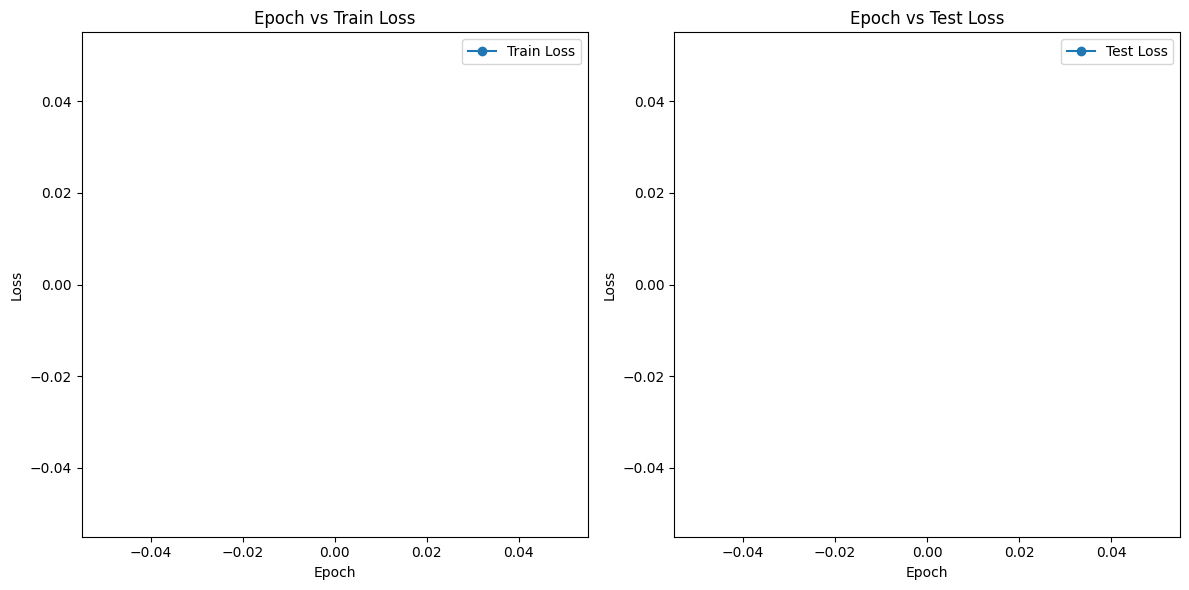

In [20]:
# Example data
epochs_range = range(1, len(train_losses) + 1)  # Assuming train_losses and test_losses have data

# Plot train loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Train Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Retrieve mean and std values for inputs and targets
input_means = [scaler.mean_ for scaler in full_dataset.input_scalers]
input_stds = [scaler.scale_ for scaler in full_dataset.input_scalers]

target_means = [scaler.mean_ for scaler in full_dataset.target_scalers]
target_stds = [scaler.scale_ for scaler in full_dataset.target_scalers]

def destandardize(data, mean, std):
    """Reverse the standardization process."""
    return data * std + mean

# Convert lists to numpy arrays for easier manipulation
train_op_1 = np.array(train_op_1)
train_op_2 = np.array(train_op_2)
test_op_1 = np.array(test_op_1)
test_op_2 = np.array(test_op_2)

# Apply destandardization for train and test outputs
train_op_1_destandardized = destandardize(train_op_1, target_means[0], target_stds[0])
train_op_2_destandardized = destandardize(train_op_2, target_means[1], target_stds[1])

test_op_1_destandardized = destandardize(test_op_1, target_means[0], target_stds[0])
test_op_2_destandardized = destandardize(test_op_2, target_means[1], target_stds[1])

# Example print statements to verify results
print("Train Output 1 (Destandardized):", train_op_1_destandardized.shape)
print("Train Output 2 (Destandardized):", train_op_2_destandardized.shape)
print("Test Output 1 (Destandardized):", test_op_1_destandardized.shape)
print("Test Output 2 (Destandardized):", test_op_2_destandardized.shape)


ValueError: operands could not be broadcast together with shapes (0,) (8515,) 